In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from pathlib import Path
from datetime import datetime
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, fbeta_score
from sklearn.metrics import make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
data_path = Path("../data/processed/earthquake_data_tsunami_scaled.csv")
data_df = pd.read_csv(data_path)

In [4]:
data_df.head()

,magnitude,cdi,mmi,sig,depth,distance_to_ocean_km,gap,tsunami
0,-0.454008,0.366134,-0.750815,0.042117,-1.273282,-0.641182,19.0,0.0
1,0.480596,1.147295,0.682949,1.802154,-0.271551,-0.641182,18.0,0.0
2,1.464696,1.387524,0.682949,1.472781,0.067414,-0.641182,36.0,0.0
3,0.215003,-1.381760,-2.007214,-0.349174,-1.273282,-0.641182,16.0,0.0
4,-1.366553,0.638393,-0.053959,-1.035334,-0.610675,-0.641182,49.0,0.0


Previously in feature engineering part, we have identified longitude, latitude, dmin, nst, Year, Month, month_number do not seem to be useful. We will exclude these features.


In [5]:
features_to_exclude = ['tsunami', 'Year', 'Month','month_number','dmin','nst','longitude','latitude']
X = data_df.drop(columns=[col for col in features_to_exclude if col in data_df.columns])
y = data_df['tsunami']

print(f"Features used: {X.columns.tolist()}")
print(f"Dataset shape: {X.shape}")
print(f"Class distribution:\n{y.value_counts()}")
print(f"Class ratio (negative/positive): {y.value_counts()[0] / y.value_counts()[1]:.2f}")


Features used: ['magnitude', 'cdi', 'mmi', 'sig', 'depth', 'distance_to_ocean_km', 'gap']
Dataset shape: (700, 7)
Class distribution:
tsunami
0.0    546
1.0    154
Name: count, dtype: int64
Class ratio (negative/positive): 3.55


Stratified K Fold is used to prevent the class imbalance and preserve the class ratio in every fold


In [6]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### XGBoost Configuration
- **scale_pos_weight**: Set to ratio of negative to positive samples (~3.55) to handle class imbalance
- **max_depth**: Limited to 4-5 to prevent overfitting on small dataset
- **learning_rate**: 0.1 for good balance between speed and performance
- **n_estimators**: 100 trees
- **subsample**: 0.8 to add regularization
- **colsample_bytree**: 0.8 for feature subsampling
- **random_state**: 42 for reproducibility


In [7]:
# Calculate scale_pos_weight (ratio of negative to positive samples)
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Create XGBoost classifier with class weights
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

scale_pos_weight: 3.55


### Cross-Validation with Multiple Metrics
We'll evaluate using accuracy, precision, recall, F1, F2 (emphasizes recall), and ROC-AUC


In [8]:
# Create F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2.0, zero_division=0)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'f2': f2_scorer,
    'roc_auc': make_scorer(roc_auc_score)
}

In [9]:
cv_results = cross_validate(
    xgb_model, X, y, 
    cv=skf, 
    scoring=scoring, 
    return_train_score=True,
    n_jobs=-1
)

Checking for overfitting by comparing train and test scores


In [10]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc']
results_summary = []

for metric in metrics:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    results_summary.append({
        'Metric': metric.upper(),
        'Train Mean': f"{train_scores.mean():.4f}",
        'Train Std': f"{train_scores.std():.4f}",
        'Test Mean': f"{test_scores.mean():.4f}",
        'Test Std': f"{test_scores.std():.4f}",
        'Gap': f"{train_scores.mean() - test_scores.mean():.4f}"
    })

results_df = pd.DataFrame(results_summary)
results_df

,Metric,Train Mean,Train Std,Test Mean,Test Std,Gap
0,ACCURACY,0.9557,0.0052,0.8343,0.0318,0.1214
1,PRECISION,0.8327,0.0167,0.6109,0.0644,0.2219
2,RECALL,1.0000,0.0000,0.6815,0.0704,0.3185
3,F1,0.9086,0.0099,0.6441,0.0668,0.2645
4,F2,0.9613,0.0044,0.6660,0.0687,0.2953
5,ROC_AUC,0.9716,0.0033,0.7794,0.0452,0.1922


In [11]:
for metric in metrics:
    train_mean = cv_results[f'train_{metric}'].mean()
    test_mean = cv_results[f'test_{metric}'].mean()
    gap = train_mean - test_mean
    print(f"{metric.upper():12} - Train: {train_mean:.4f}, Test: {test_mean:.4f}, Gap: {gap:+.4f}")


ACCURACY     - Train: 0.9557, Test: 0.8343, Gap: +0.1214
PRECISION    - Train: 0.8327, Test: 0.6109, Gap: +0.2219
RECALL       - Train: 1.0000, Test: 0.6815, Gap: +0.3185
F1           - Train: 0.9086, Test: 0.6441, Gap: +0.2645
F2           - Train: 0.9613, Test: 0.6660, Gap: +0.2953
ROC_AUC      - Train: 0.9716, Test: 0.7794, Gap: +0.1922


### Confusion Matrix Analysis


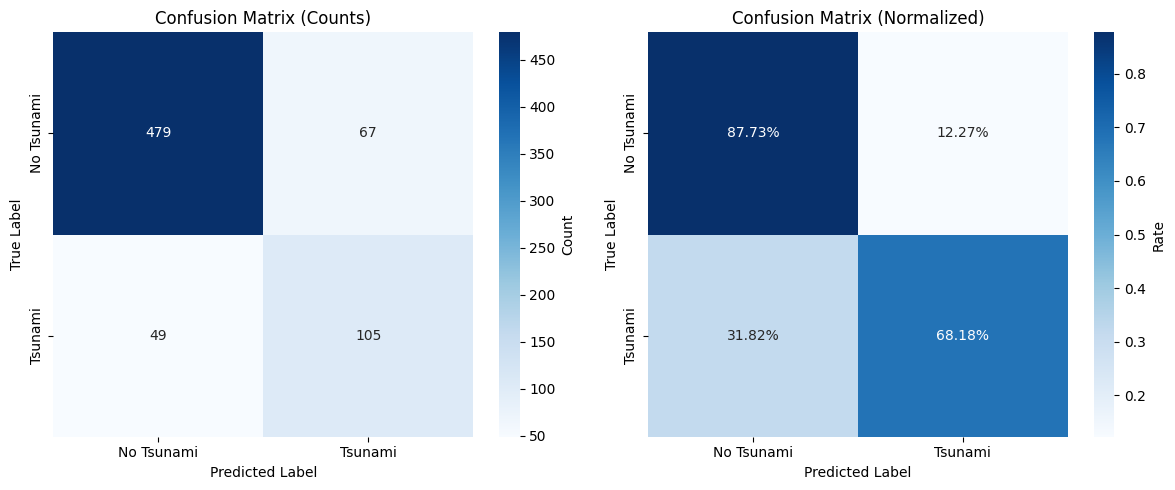


False Negative Rate: 31.82%
True Positives: 105, False Negatives: 49
True Negatives: 479, False Positives: 67


In [12]:
y_pred_cv = cross_val_predict(xgb_model, X, y, cv=skf, n_jobs=-1, method='predict')
y_proba_cv = cross_val_predict(xgb_model, X, y, cv=skf, n_jobs=-1, method='predict_proba')[:, 1]

cm = confusion_matrix(y, y_pred_cv)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[0].set_yticklabels(['No Tsunami', 'Tsunami'])

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Rate'})
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[1].set_yticklabels(['No Tsunami', 'Tsunami'])

plt.tight_layout()
plt.show()

# Calculate false negative rate
fn_rate = cm[1, 0] / cm[1, :].sum() * 100
print(f"\nFalse Negative Rate: {fn_rate:.2f}%")
print(f"True Positives: {cm[1, 1]}, False Negatives: {cm[1, 0]}")
print(f"True Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}")


### Save Results to XLSX


In [13]:
results_dir = Path("../models")
results_dir.mkdir(parents=True, exist_ok=True)
results_xlsx = results_dir / "model_results.xlsx"

# Calculate final metrics from cross-validation predictions
final_accuracy = accuracy_score(y, y_pred_cv)
final_precision = precision_score(y, y_pred_cv, zero_division=0)
final_recall = recall_score(y, y_pred_cv)
final_f1 = f1_score(y, y_pred_cv)
final_f2 = fbeta_score(y, y_pred_cv, beta=2.0, zero_division=0)
final_roc_auc = roc_auc_score(y, y_proba_cv)

xgb_results = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model": "XGBoost",
    "cv_splits": skf.get_n_splits(),
    "scaler": "PowerTransformer+StandardScaler",
    "class_weight": f"scale_pos_weight={scale_pos_weight:.2f}",
    "test_accuracy": cv_results["test_accuracy"].mean(),
    "test_precision": cv_results["test_precision"].mean(),
    "test_recall": cv_results["test_recall"].mean(),
    "test_f1": cv_results["test_f1"].mean(),
    "test_f2": cv_results["test_f2"].mean(),
    "test_roc_auc": cv_results["test_roc_auc"].mean(),
    "train_accuracy": cv_results["train_accuracy"].mean(),
    "train_precision": cv_results["train_precision"].mean(),
    "train_recall": cv_results["train_recall"].mean(),
    "train_f1": cv_results["train_f1"].mean(),
    "train_f2": cv_results["train_f2"].mean(),
    "train_roc_auc": cv_results["train_roc_auc"].mean(),
    "train_test_gap_accuracy": cv_results["train_accuracy"].mean() - cv_results["test_accuracy"].mean(),
    "false_negative_rate": fn_rate,
    "notes": f"max_depth=4, learning_rate=0.1, n_estimators=100"
}

new_results_df = pd.DataFrame([xgb_results])
if results_xlsx.exists():
    existing_results = pd.read_excel(results_xlsx)
    model_comparison = pd.concat([existing_results, new_results_df], ignore_index=True)
    model_comparison.to_excel(results_xlsx, index=False)
else:
    new_results_df.to_excel(results_xlsx, index=False)
    
new_results_df.T

,0
timestamp,2025-12-11 17:36:40
model,XGBoost
cv_splits,5
scaler,PowerTransformer+StandardScaler
class_weight,scale_pos_weight=3.55
test_accuracy,0.834286
test_precision,0.61086
test_recall,0.681505
test_f1,0.644125
test_f2,0.666009


## XGBoost Model Results Summary

**Key Findings:**
- **Test Accuracy**: 0.8343 (83.43%)
- **Test Precision**: 0.6109 (61.09%)
- **Test Recall**: 0.6815 (68.15%) - Successfully detects tsunamis
- **Test F1 Score**: 0.6441 (64.41%)
- **Test F2 Score**: 0.6660 (66.60%) - Optimized for recall (critical for tsunami detection)
- **Test ROC-AUC**: 0.7794 (77.94%) - Good class separation
- **False Negative Rate**: 31.82% - Critical metric for safety
- **Train/Test Gap (Accuracy)**: 0.1214 (12.14%) - Some overfitting present

**Model Configuration:**
- Class imbalance handled via `scale_pos_weight=3.55` parameter
- Regularization: max_depth=4, subsample=0.8, colsample_bytree=0.8
- Learning rate: 0.1 with 100 estimators

**Next Steps:**
- Compare with other gradient boosting models (LightGBM, CatBoost)
- Consider hyperparameter tuning for better F2 score and reduced overfitting
- Evaluate ensemble methods combining multiple models
